In [1]:
import numpy as np
import pandas as pd
from toolz import curry
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv("data/smoking.csv")
data = data.pivot("year", "state", "cigsale")

data = data.rename(columns={c: f"state_{c}" for c in data.columns}).rename(columns={"state_3": "california"})
print(data.shape)
data.head()

(31, 39)


state,state_1,state_2,california,state_4,state_5,state_6,state_7,state_8,state_9,state_10,...,state_30,state_31,state_32,state_33,state_34,state_35,state_36,state_37,state_38,state_39
year,,,,,,,,,,,,,,,,,,,,,
1970,89.800003,100.300003,123.000000,124.800003,120.000000,155.000000,109.900002,102.400002,124.800003,134.600006,...,103.599998,92.699997,99.800003,106.400002,65.500000,122.599998,124.300003,114.500000,106.400002,132.199997
1971,95.400002,104.099998,121.000000,125.500000,117.599998,161.100006,115.699997,108.500000,125.599998,139.300003,...,115.000000,96.699997,106.300003,108.900002,67.699997,124.400002,128.399994,111.500000,105.400002,131.699997
1972,101.099998,103.900002,123.500000,134.300003,110.800003,156.300003,117.000000,126.099998,126.599998,149.199997,...,118.699997,103.000000,111.500000,108.599998,71.300003,138.000000,137.000000,117.500000,108.800003,140.000000
1973,102.900002,108.000000,124.400002,137.899994,109.300003,154.699997,119.800003,121.800003,124.400002,156.000000,...,125.500000,103.500000,109.699997,110.400002,72.699997,146.800003,143.100006,116.599998,109.500000,141.199997
1974,108.199997,109.699997,126.699997,132.800003,112.400002,151.300003,123.699997,125.599998,131.899994,159.600006,...,129.699997,108.400002,114.800003,114.699997,75.599998,151.800003,149.600006,119.900002,111.800003,145.800003


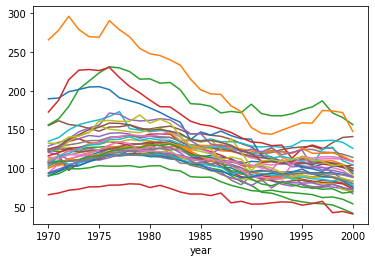

In [3]:
data.plot(legend=None);

## Synthetic Control

In [4]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = Pipeline([('scaler', StandardScaler()),
                  ('lasso', LassoCV(max_iter=5000, fit_intercept=True, positive=True))])


train = data[data.index < 1988]
test = data[data.index >= 1988]

model.fit(train.drop(columns=["california"]), train["california"])

model.steps[-1][-1].coef_

array([0.        , 0.        , 0.4354481 , 1.41407579, 0.        ,
       0.        , 0.        , 0.49843166, 0.        , 0.        ,
       0.30078638, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.38431034, 0.        , 5.52228194,
       0.93967834, 0.        , 0.70455999, 0.        , 0.        ,
       0.        , 0.        , 0.08773524, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.21034342, 0.        , 0.        ])

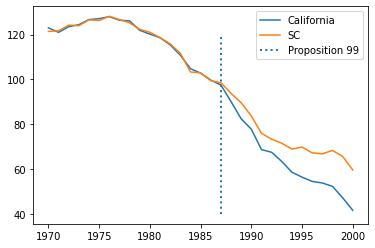

In [5]:
plt.plot(data["california"], label="California")
plt.plot(data["california"].index, model.predict(data.drop(columns=["california"])), label="SC")
plt.vlines(x=1987, ymin=40, ymax=120, linestyle=":", lw=2, label="Proposition 99")

plt.legend();

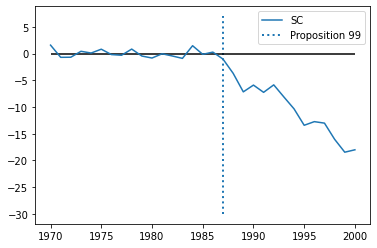

In [6]:
cum_est_effect = data["california"] - model.predict(data.drop(columns=["california"]))

plt.plot(cum_est_effect, label="SC")
plt.vlines(x=1987, ymin=-30, ymax=7, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(0, 1970, 2000, color="black")
plt.legend();

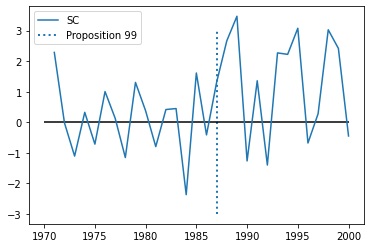

In [7]:
plt.plot(cum_est_effect.shift(1) - cum_est_effect, label="SC")
plt.vlines(x=1987, ymin=-3, ymax=3, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(0, 1970, 2000, color="black")
plt.legend();

# Conformal Inference

## Simulate Effect

In [8]:
def with_cum_effect(df, state, effect_size, start_at, window):

    window_mask = (df.index>=start_at) & (df.index < (start_at+window))
    y = df[state] + window_mask*(df.index-start_at)*effect_size
    
    return df.assign(**{state: y})


def with_effect(df, state, effect_size, start_at, window):
    window_mask = (df.index>=start_at) & (df.index < (start_at +window))
    
    y = np.where(window_mask, df[state] + effect_size, df[state])
    
    return df.assign(**{state: y})

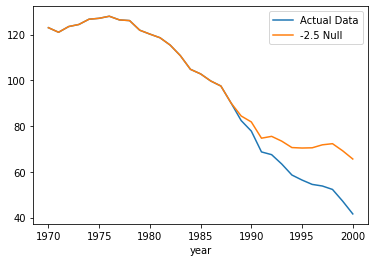

In [9]:
ax = with_cum_effect(data, "california", .0, 1988, 2000-1988+1)["california"].plot(label="Actual Data")
ax = with_cum_effect(data, "california", +2, 1988, 2000-1988+1)["california"].plot(ax=ax, label="-2.5 Null")
plt.legend()

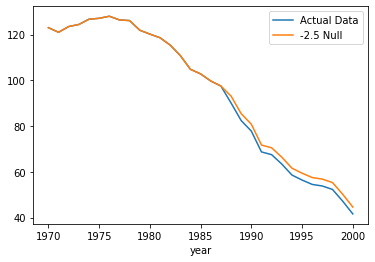

In [10]:
ax = with_effect(data, "california", .0, 1988, 2000-1988+1)["california"].plot(label="Actual Data")
ax = with_effect(data, "california", +3, 1988, 2000-1988+1)["california"].plot(ax=ax, label="-2.5 Null")
plt.legend()

# Conformal Inference

In [11]:
from sklearn.linear_model import Lasso, LinearRegression

@curry
def residuals(df, state, null, intervention_start, window, model):
    
    null_data = with_effect(df, state, -null, intervention_start, window)
            
    model.fit(null_data.drop(columns=[state]), null_data[state])
    
    
    test_mask = (null_data.index > intervention_start) & (null_data.index < (intervention_start + window))
    
    y0_est = pd.Series(model.predict(null_data.drop(columns=[state])), index=df.index)
    
    residuals = df[state] - y0_est
    
    return pd.DataFrame({
        "y": df[state],
        "y_0": y0_est,
        "y_cum": df[state].cumsum(),
        "y_cum_window": (test_mask*df[state]).cumsum(),
        "residuals": residuals,
        "window": test_mask
    })[lambda d: d.index < (intervention_start + window)]
    


def p_val(resid_df):
    
    # l1 norm
    t_stats = [pd.DataFrame(np.roll(resid_df, roll, axis=0), index=resid_df.index, columns=resid_df.columns)[resid_df["window"].values]["residuals"].abs().mean()
               for roll in range(resid_df.shape[0])] 
        
    return (t_stats[0] <= np.array(t_stats)).mean()



def conf_int(df, state, nulls, intervention_start, window, model):
    
    return [p_val(residuals(df, state, null, intervention_start, window, model)) for null in nulls]

In [12]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = Pipeline([('scaler', StandardScaler()),
                  ('lasso', Lasso(alpha=1, max_iter=5000, fit_intercept=True, positive=True))])

est_effect = residuals(data,
                       "california",
                       null=0.0,
                       intervention_start=1988,
                       window=2000-1988,
                       model=model)

p_val(est_effect)

0.3333333333333333

In [13]:
est_effect.head()

,y,y_0,y_cum,y_cum_window,residuals,window
year,,,,,,
1970,123.000000,120.219386,123.000000,0.0,2.780614,False
1971,121.000000,120.358656,244.000000,0.0,0.641344,False
1972,123.500000,121.994084,367.500000,0.0,1.505916,False
1973,124.400002,122.462159,491.900002,0.0,1.937843,False
1974,126.699997,126.023434,618.599998,0.0,0.676563,False


In [14]:
model.steps[-1][-1].coef_

array([ 0.        ,  0.        ,  4.2186229 ,  7.49812766,  0.        ,
        0.        ,  0.09001768,  5.11032216,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.90821904,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , 10.02731729,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.45990461,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

<AxesSubplot:xlabel='year'>

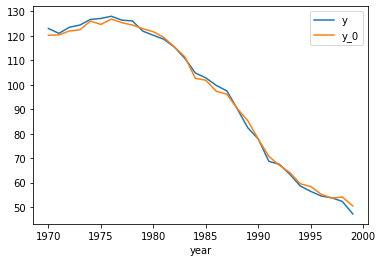

In [15]:
est_effect[["y", "y_0"]].plot()

<AxesSubplot:xlabel='year'>

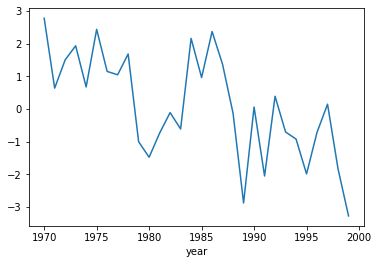

In [16]:
est_effect["residuals"].plot()

In [17]:
nulls = np.linspace(-2, 6, 100)

p_vals = conf_int(data,
                  "california",
                  nulls=nulls,
                  intervention_start=1988,
                  window=2000-1988,
                  model=model)

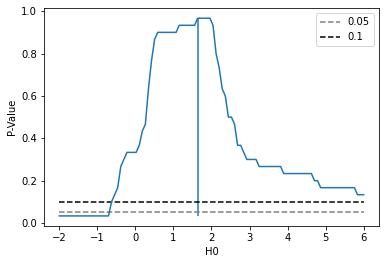

In [18]:
plt.plot(nulls, p_vals)
plt.vlines(nulls[np.argmax(p_vals)], min(p_vals), max(p_vals))
plt.hlines(0.05, nulls.min(), nulls.max(), color="gray", ls="dashed", label="0.05")
plt.hlines(0.1, nulls.min(), nulls.max(), color="black", ls="dashed", label="0.1")
plt.legend()
plt.ylabel("P-Value")
plt.xlabel("H0");